In [1]:
import geopandas as gpd
import pandas as pd

### Data for Roads and Traffic in Greater London

Download dataset from https://download.geofabrik.de/europe/great-britain/england/greater-london.html

In [2]:
path = 'Data/london_geofabrik/'
roads = gpd.read_file(path + 'gis_osm_roads_free_1.shp')
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,74,5113,primary,Ballards Lane,A598,B,48,0,F,F,"LINESTRING (-0.19312 51.60172, -0.19297 51.60186)"
1,75,5113,primary,High Road,A1000,B,48,0,F,F,"LINESTRING (-0.17679 51.61732, -0.17679 51.616..."
2,79,5113,primary,East End Road,A504,B,48,0,F,F,"LINESTRING (-0.19799 51.59712, -0.19778 51.596..."
3,482,5113,primary,Cockfosters Road,A111,B,48,0,F,F,"LINESTRING (-0.16075 51.67152, -0.16070 51.671..."
4,488,5122,residential,Western Way,None,B,32,0,F,F,"LINESTRING (-0.18865 51.64062, -0.18862 51.640..."


<AxesSubplot:>

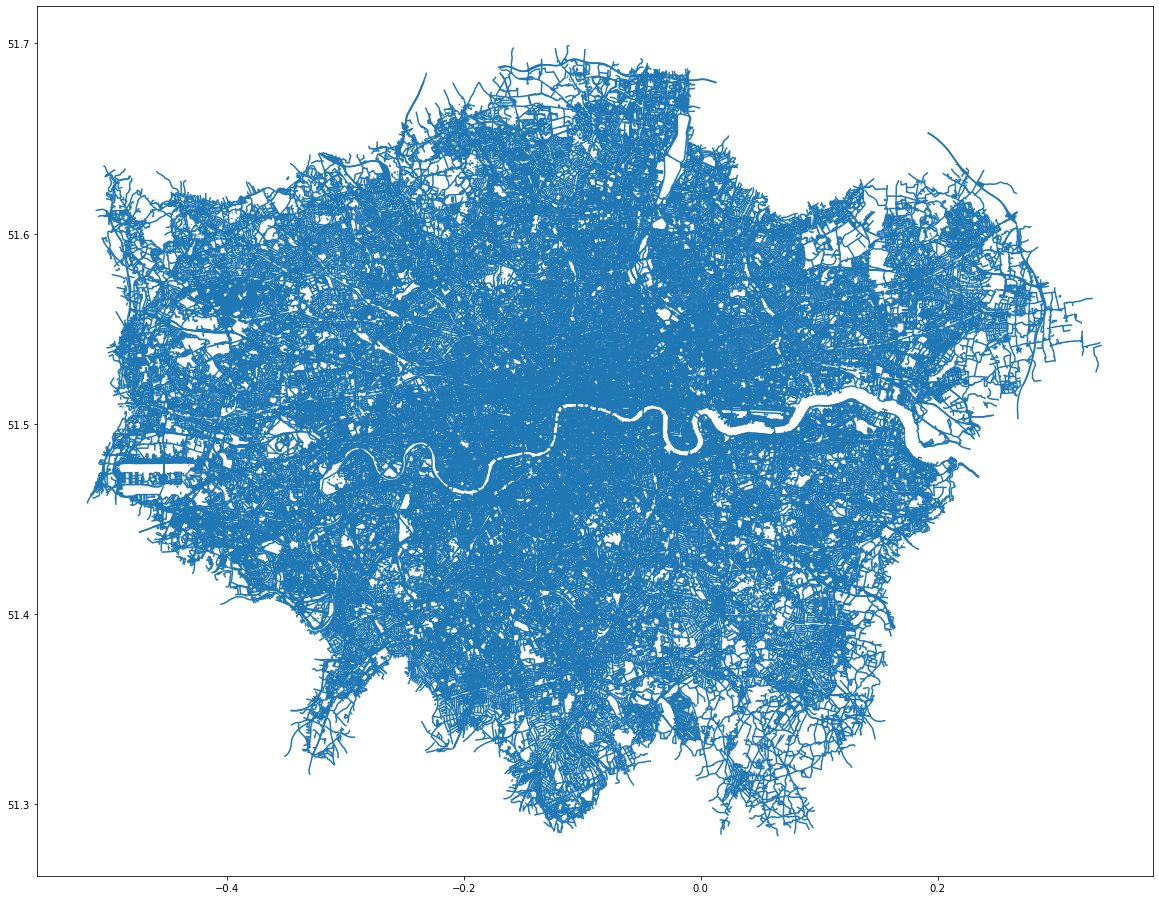

In [3]:
roads.plot(figsize=(20,20))

In [4]:
roads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

##### Convert Coordinate Reference System
Project the crs to something that can flatten the map (remove 'curvatures') so that transformations can be done in cartesian coordinates.

In [5]:
roads = roads.to_crs('+proj=cea')

<AxesSubplot:>

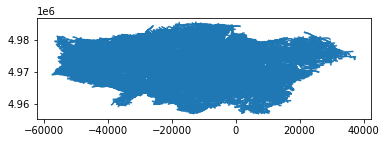

In [6]:
roads.plot()

In [7]:
roads.shape

(394252, 11)

In [8]:
roads.fclass.unique()

array(['primary', 'residential', 'trunk', 'footway', 'service',
       'unclassified', 'tertiary', 'primary_link', 'secondary',
       'motorway_link', 'cycleway', 'motorway', 'tertiary_link',
       'bridleway', 'trunk_link', 'pedestrian', 'living_street', 'steps',
       'track', 'path', 'track_grade2', 'track_grade5', 'secondary_link',
       'track_grade1', 'track_grade3', 'track_grade4', 'unknown'],
      dtype=object)

###### Only get road classes that would be suitable for cars.


Filtering based on wikipedia: https://wiki.openstreetmap.org/wiki/Key:highway

In [9]:
roads_filter = ['service', 'primary', 'tertiary', 'secondary', 'unclassified', 'trunk',
       'motorway_link', 'motorway', 'trunk_link', 'primary_link',
       'living_street', 'tertiary_link', 'secondary_link']

car_roads = roads[roads.fclass.isin(roads_filter)]
car_roads.shape

(155783, 11)

##### Traffic Data in Greater London

In [10]:
traffic = gpd.read_file(path + 'gis_osm_traffic_a_free_1.shp')

In [11]:
traffic = traffic.to_crs('+proj=cea') # aligning the traffic crs to the roads crs.

In [12]:
traffic.head()

,osm_id,code,fclass,name,geometry
0,2956081,5260,parking,None,"POLYGON ((-2429.759 4967390.810, -2237.188 496..."
1,2956183,5260,parking,Thornes Lane Car Park,"POLYGON ((-2501.316 4967968.494, -2485.453 496..."
2,2956184,5260,parking,None,"POLYGON ((-2078.368 4967895.979, -2064.331 496..."
3,2956185,5260,parking,None,"POLYGON ((-2113.356 4968172.160, -2108.580 496..."
4,2956473,5260,parking,None,"POLYGON ((-663.486 4968846.949, -653.390 49688..."


<AxesSubplot:>

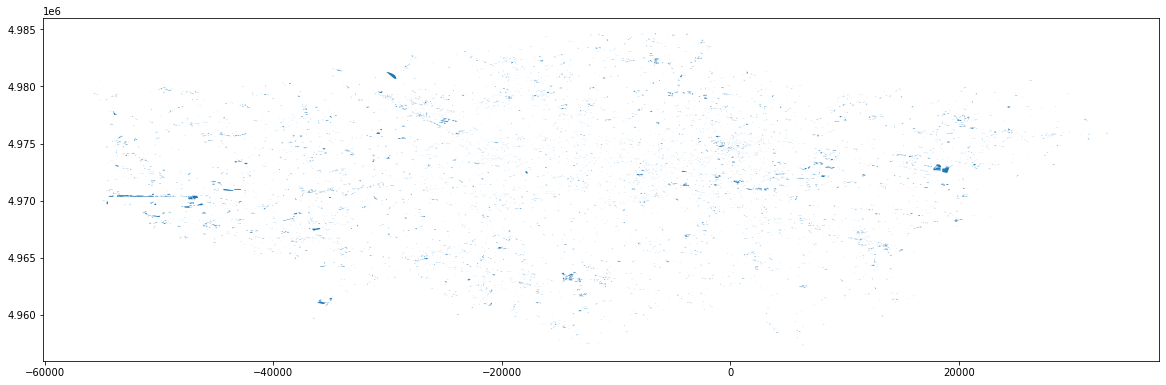

In [13]:
traffic.plot(figsize=(20, 20))

In [14]:
traffic.shape

(12430, 5)

##### Traffic data augmentation
1. Get boundaries (linestring) of the polygons to enable geopandas sjoin with roads data.
2. Create column to indicate mini-nodes using Traffic data through ranking of polygon shape (these will have to aggregated post join with roads data).

In [15]:
# traffic['boundary'] = traffic.geometry.boundary
# traffic.head()

In [16]:
traffic_crs = traffic.crs
traffic_crs

<Projected CRS: +proj=cea +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Cylindrical Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
traffic['area'] = traffic.area
traffic = traffic.sort_values(by='area', ascending=False) # ordering to the get the biggest traffic zones.
traffic.head(8)

,osm_id,code,fclass,name,geometry,area
1127,60085305,5260,parking,Frog Island Vehicle Holding Centre,"POLYGON ((18525.712 4972517.365, 18574.214 497...",219346.814122
1165,61402235,5251,service,London Gateway Services,"POLYGON ((-30116.820 4981272.273, -30052.478 4...",179960.917016
763,37935390,5260,parking,Heathrow Long Stay Terms 2 & 3,"POLYGON ((-47123.489 4970425.247, -46999.757 4...",108018.868717
1128,60085307,5260,parking,Autotech Compound,"POLYGON ((18006.395 4973074.839, 18012.329 497...",87539.180134
3992,206555474,5302,marina,None,"POLYGON ((-36630.057 4967533.568, -36560.193 4...",86940.674307
5373,377329515,5260,parking,Chessington World of Adventures Explorer Car Park,"POLYGON ((-36223.774 4961031.953, -36096.369 4...",86255.074048
1166,61402311,5251,service,Moto Heston Services,"POLYGON ((-44381.701 4970917.990, -44374.543 4...",79893.630480
12068,1047919606,5260,parking,LHR Terminal 5 Long Stay Parking,"POLYGON ((-52304.042 4970316.800, -52303.852 4...",61203.503675


#### Merging the Roads and Traffic datasets 

In [18]:
roads_traffic = gpd.sjoin(roads, traffic, how='inner').sort_values(by='area', ascending=False)
roads_traffic.shape

(23388, 17)

In [19]:
roads_traffic.head()

,osm_id_left,code_left,fclass_left,name_left,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,index_right,osm_id_right,code_right,fclass_right,name_right,area
345606,959742571,5141,service,None,None,B,0,0,F,F,"LINESTRING (18766.908 4972826.443, 18769.702 4...",1127,60085305,5260,parking,Frog Island Vehicle Holding Centre,219346.814122
345618,959742583,5141,service,None,None,F,0,0,F,F,"LINESTRING (18703.077 4972813.483, 18693.225 4...",1127,60085305,5260,parking,Frog Island Vehicle Holding Centre,219346.814122
345616,959742581,5141,service,None,None,F,0,0,F,F,"LINESTRING (18597.802 4972541.872, 18596.121 4...",1127,60085305,5260,parking,Frog Island Vehicle Holding Centre,219346.814122
345615,959742580,5141,service,None,None,F,0,0,F,F,"LINESTRING (19035.343 4972824.612, 19077.634 4...",1127,60085305,5260,parking,Frog Island Vehicle Holding Centre,219346.814122
345614,959742579,5141,service,None,None,B,0,0,F,F,"LINESTRING (18893.778 4972826.117, 18910.710 4...",1127,60085305,5260,parking,Frog Island Vehicle Holding Centre,219346.814122


##### Plot roads and highligh traffic area zones in them.

<AxesSubplot:>

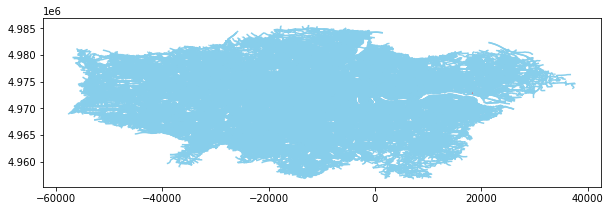

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

roads_plot = roads.geometry.plot(ax=ax, color='skyblue', edgecolor='black')

traffic.plot(ax=roads_plot, color='red', markersize=20)

##### Aggregate Traffic zones to create nodes

<AxesSubplot:>

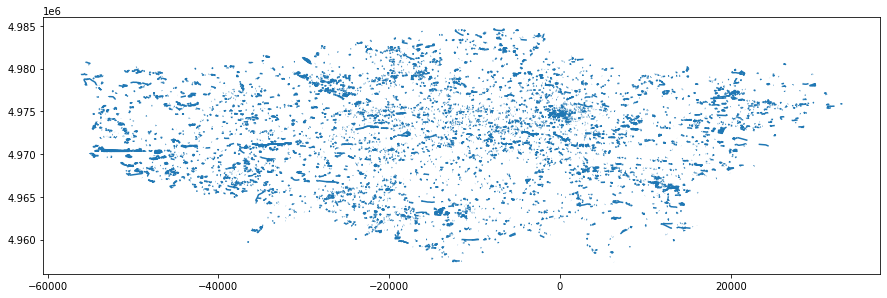

In [27]:
roads_traffic.plot(figsize=(15, 15))